# Лабораторная работа №6

**Тема: "Дискретное косинусное преобразование"**

Работу выполнил

студент группы 5130901/20201

Нестеренко Сергей Андреевич

---

In [3]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [38]:
from thinkdsp import normalize, unbias, read_wave, PinkNoise, decorate, UncorrelatedGaussianNoise, Spectrum, Spectrogram, Wave, Noise, PI2, Dct
from scipy.stats import linregress
from scipy.fftpack import dct

import numpy as np
import matplotlib.pyplot as plt

## Упражнение 6.1

Автор учебника заявляет, что функция `analyze1` имеет сложность по времени $O(n^3)$, а `analyze2` -- $O(n^2)$. Проверим это на практике.

Объявим нужные функции.

In [5]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [6]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = M.dot(ys) / 2
    return amps

Сгенерируем UG-шум.

In [7]:
ug_signal = UncorrelatedGaussianNoise()
ug = ug_signal.make_wave(duration=1, framerate=10000)

Напишем функцию для подсчета времени работы заданной функции с заданными количествами параметров.

`ns` -- массив, содержащий различные значения `N`

`func` -- целевая функция 

In [8]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = ug.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

Также создадим функцию для вывода графика зависимости времени выполнения целевой функции от количества параметров (в логарифмическом масштабе). Также эта функция будет вычислять наклон полученной прямой при помощи линейной регрессии.

In [9]:
def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    decorate(xscale='log', yscale='log')
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x, y)
    slope = t[0]

    return slope

Зададим массив `ns`, общий для всех тестов:

In [10]:
ns = 2 ** np.arange(5, 14)
ns

array([  32,   64,  128,  256,  512, 1024, 2048, 4096, 8192])

### 6.1.1. Функция `analyze1`

In [11]:
bests1 = run_speed_test(ns, analyze1)

32
78.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
64
192 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
619 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
2.85 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
18.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
88.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
517 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
3.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192
21.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


np.float64(2.3125586193591805)

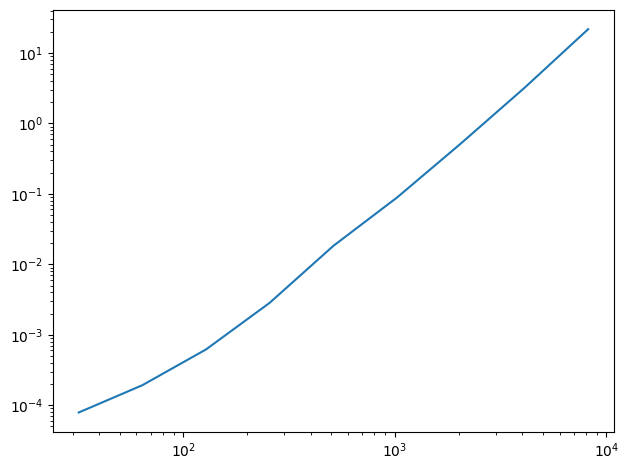

In [12]:
plot_bests(ns, bests1)

Получим значение наклона `2.32`. Такое значение свидетельствует о том, что временная асимптотическая сложность алгоритма действительно больше $O(n^2)$, однако на рассмотренных выборках данных по какой-то причине сложность алгоритма выглядит более близкой к $O(n^2)$, чем к $O(n^3)$.

### 6.1.2. Функция `analyze2`

In [13]:
bests2 = run_speed_test(ns, analyze2)

32
39.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
64
101 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
335 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
1.24 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
6.82 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
26.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
107 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
425 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192
1.76 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


np.float64(1.981304529451397)

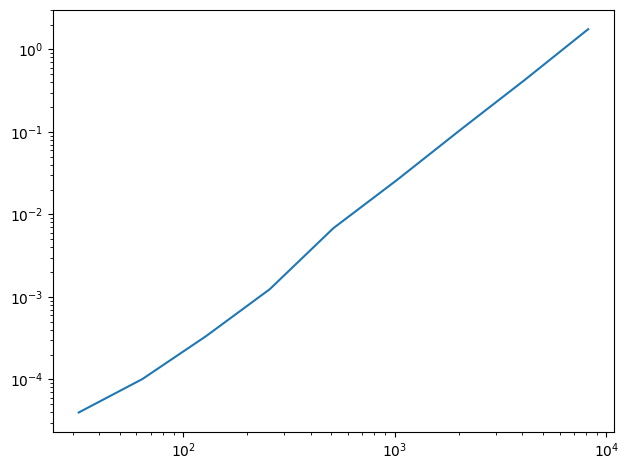

In [14]:
plot_bests(ns, bests2)

В данном случае получено значение наклона `1.99`, что близко к заявленной сложности алгоритма.

Поупражняемся также с функциями `dct_iv` и `scipy.fftpack.dct`.

Объявим функцию `dct_iv`.

In [15]:
def dct_iv(ys):
    N = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Добавим функции-обертки для `dct_iv` и `dct`, чтобы не писать новые тестирующие функции.

In [16]:
def dct_iv_wrapper(ys, fs, ts):
    return dct_iv(ys)

def dct_wrapper(ys, fs, ts):
    return dct(ys)

### 6.1.3. Функция `dct_iv`

In [17]:
bests3 = run_speed_test(ns, dct_iv_wrapper)

32
55.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
64
129 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
348 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
1.29 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
7.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
24.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
109 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
439 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8192
1.76 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


np.float64(1.9304395715771636)

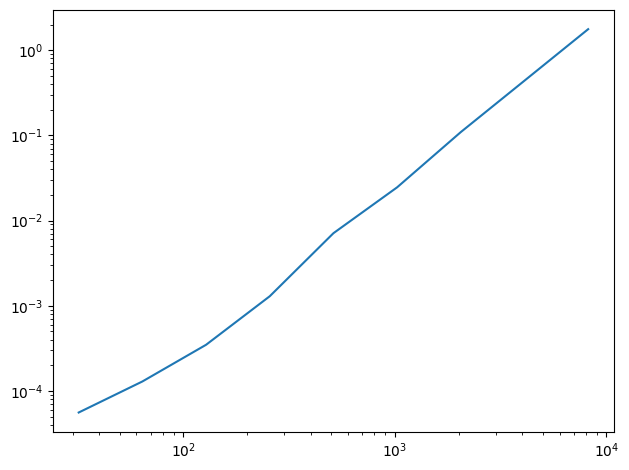

In [18]:
plot_bests(ns, bests3)

Получено, что сложность алгоритма `dct_iv` -- $O(n^2)$.

### 6.1.4. Функция `scipy.fftpack.dct`

In [19]:
bests4 = run_speed_test(ns, dct_wrapper)

32
11.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
64
12 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
128
12.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
256
13.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
512
16.6 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
1024
22 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
2048
34.3 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
4096
64.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
8192
108 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


np.float64(0.3949295655872743)

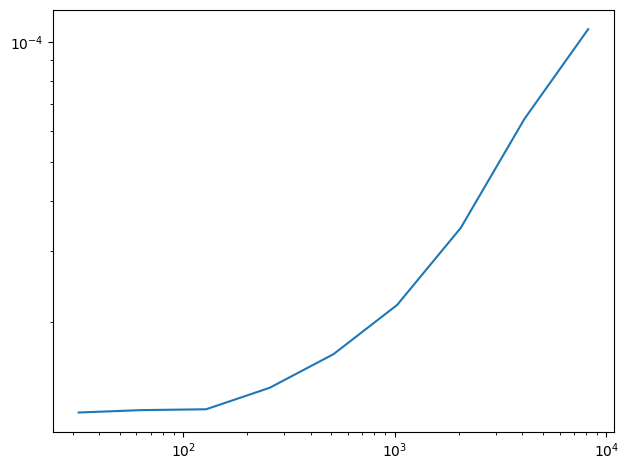

In [20]:
plot_bests(ns, bests4)

Сложность алгоритма `scipy.fftpack.dct` не выражается в виде $O(n^k)$, однако, вероятно, меньше, чем у всех рассмотренных ранее функций.

## Упражнение 6.2

Реализуем алгоритм сжатия звука на основе ДКП. Для этого будем на небольших сегментах записи удалять из сигнала такие частотные компоненты, амплитуда которых достаточно низка и которые почти не слышно.

Для примера воспользуемся записью саксофона, использованной ранее.

In [23]:
wave = read_wave('./audio/code_100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Возьмем небольшой сегмент записи.

In [24]:
segment = wave.segment(start=4, duration=0.5)
segment.normalize()
segment.make_audio()

Получим ДКП сегмента:

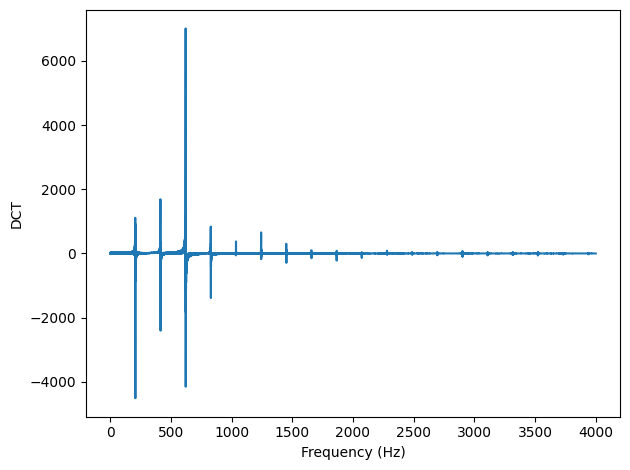

In [25]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Напишем функцию, которая принимает ДКП сигнала и зануляет все элементы, меньшие некоторого порогового значения.

In [34]:
def compress(dct: Dct, threshold: np.int64):
    cnt = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < threshold:
            dct.hs[i] = 0
            cnt += 1
    n = len(dct.amps)
    print(f'{(cnt / n * 100):.2f}% of entries eliminated.')

Применим её на полученном ДКП.

93.07% of entries eliminated.


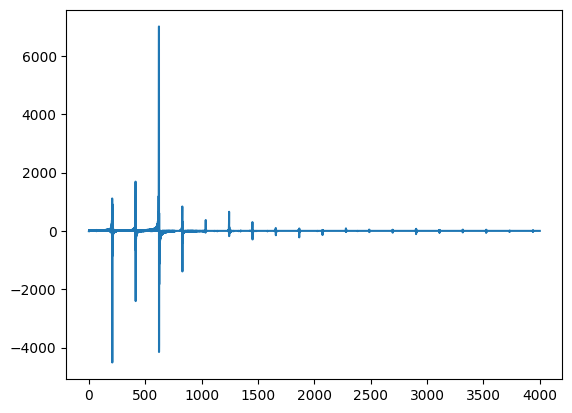

In [35]:
seg_dct = segment.make_dct()
compress(seg_dct, threshold=10)
seg_dct.plot(high=4000)

Прослушаем результат. Он звучит примерно так же, как исходный сегмент.

In [37]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Теперь попробуем удалить больше элементов.

In [45]:
dct = wave.segment(start=4, duration=0.5).make_dct()
compress(dct, threshold=400)
dct.make_wave().make_audio()

99.87% of entries eliminated.


С почти всеми (в процентном соотношении) удаленными элементами всё ещё можно различить и тембр саксофона, и звучащую ноту, однако очевидно, что качество звука стало заметно хуже. Тем не менее, возможно, такая высокая степень сжатия может быть полезна в некоторых ситуациях, где экономия памяти значительно более приоритетна, чем сохранение качества записи.

Итак, наш алгоритм работает для отдельного сегмента. Чтобы применить его на весь аудиофайл, сделаем на его основе ДКП-спектрограмму аналогично методу `make_spectrogram`.

In [40]:
def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Создадим ДКП-спектрограмму на основе `wave` и применим к каждому элементу функцию `compress`.

In [43]:
dcp_sp = make_dct_spectrogram(wave, 1024)
for _, dct in dcp_sp.spec_map.items():
    compress(dct, threshold=0.2)

99.41% of entries eliminated.
99.22% of entries eliminated.
99.02% of entries eliminated.
99.32% of entries eliminated.
99.22% of entries eliminated.
99.32% of entries eliminated.
99.22% of entries eliminated.
99.61% of entries eliminated.
99.02% of entries eliminated.
98.14% of entries eliminated.
98.54% of entries eliminated.
99.12% of entries eliminated.
99.12% of entries eliminated.
99.22% of entries eliminated.
99.22% of entries eliminated.
99.12% of entries eliminated.
99.32% of entries eliminated.
99.61% of entries eliminated.
98.93% of entries eliminated.
99.32% of entries eliminated.
98.93% of entries eliminated.
99.32% of entries eliminated.
99.41% of entries eliminated.
99.12% of entries eliminated.
98.93% of entries eliminated.
77.54% of entries eliminated.
76.66% of entries eliminated.
93.26% of entries eliminated.
97.17% of entries eliminated.
96.88% of entries eliminated.
95.31% of entries eliminated.
90.33% of entries eliminated.
78.32% of entries eliminated.
81.64% of 

72.85% of entries eliminated.
74.90% of entries eliminated.
73.14% of entries eliminated.
73.14% of entries eliminated.
72.07% of entries eliminated.
71.88% of entries eliminated.
72.95% of entries eliminated.
74.22% of entries eliminated.
71.97% of entries eliminated.
73.44% of entries eliminated.
73.83% of entries eliminated.
75.39% of entries eliminated.
72.27% of entries eliminated.
71.97% of entries eliminated.
74.80% of entries eliminated.
77.25% of entries eliminated.
74.71% of entries eliminated.
75.29% of entries eliminated.
76.76% of entries eliminated.
75.20% of entries eliminated.
74.32% of entries eliminated.
74.71% of entries eliminated.
73.83% of entries eliminated.
74.02% of entries eliminated.
74.71% of entries eliminated.
76.66% of entries eliminated.
75.10% of entries eliminated.
76.27% of entries eliminated.
77.34% of entries eliminated.
77.93% of entries eliminated.
79.00% of entries eliminated.
75.98% of entries eliminated.
76.37% of entries eliminated.
75.78% of 

84.08% of entries eliminated.
86.04% of entries eliminated.
86.13% of entries eliminated.
85.35% of entries eliminated.
85.45% of entries eliminated.
84.57% of entries eliminated.
84.96% of entries eliminated.
86.23% of entries eliminated.
84.96% of entries eliminated.
85.06% of entries eliminated.
85.64% of entries eliminated.
84.57% of entries eliminated.
85.64% of entries eliminated.
84.28% of entries eliminated.
85.25% of entries eliminated.
85.06% of entries eliminated.
86.23% of entries eliminated.
84.18% of entries eliminated.
83.30% of entries eliminated.
83.79% of entries eliminated.
83.69% of entries eliminated.
83.50% of entries eliminated.
82.71% of entries eliminated.
81.74% of entries eliminated.
83.01% of entries eliminated.
84.38% of entries eliminated.
85.84% of entries eliminated.
86.23% of entries eliminated.
85.06% of entries eliminated.
86.72% of entries eliminated.
86.04% of entries eliminated.
81.05% of entries eliminated.
84.96% of entries eliminated.
85.64% of 

96.09% of entries eliminated.
96.29% of entries eliminated.
96.39% of entries eliminated.
97.27% of entries eliminated.
97.17% of entries eliminated.
97.36% of entries eliminated.
97.56% of entries eliminated.
97.85% of entries eliminated.
97.56% of entries eliminated.
98.05% of entries eliminated.
97.85% of entries eliminated.
97.56% of entries eliminated.
97.66% of entries eliminated.
98.34% of entries eliminated.
98.63% of entries eliminated.
98.83% of entries eliminated.
98.05% of entries eliminated.
97.66% of entries eliminated.
98.44% of entries eliminated.
98.14% of entries eliminated.
98.73% of entries eliminated.
98.73% of entries eliminated.
98.54% of entries eliminated.
98.14% of entries eliminated.
98.34% of entries eliminated.
98.63% of entries eliminated.
98.63% of entries eliminated.
98.14% of entries eliminated.
98.44% of entries eliminated.
98.83% of entries eliminated.
98.54% of entries eliminated.
98.83% of entries eliminated.
98.93% of entries eliminated.
98.63% of 

Преобразуем ДКП-спектрограмму обратно в `Wave`. Получим сжатый аудиофайл, который, тем не менее, звучит почти точно так же, как исходный.

In [44]:
dcp_sp.make_wave().make_audio()

## Упражнение 6.3

В блокноте `phase.ipynb` автор исследует влияние фазы на восприятие звука. Повторим эксперименты на примере иного сегмента звука.

Объявим необходимые для работы функции.

In [61]:
def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)', 
             ylabel='Phase (radian)')

def plot_three(spectrum, thresh=1):
    """Plot amplitude, phase, and waveform.
    
    spectrum: Spectrum object
    thresh: threshold passed to plot_angle
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

Считаем аудиофайл.

In [46]:
wave = read_wave('./audio/120994__thirsk__120-oboe.wav')
wave.make_audio()

Возьмем небольшой сегмент.

In [53]:
segment = wave.segment(start=4.1, duration=0.9)

Получим аудио, а также визуализируем амплитуды, углы и форму сигнала.

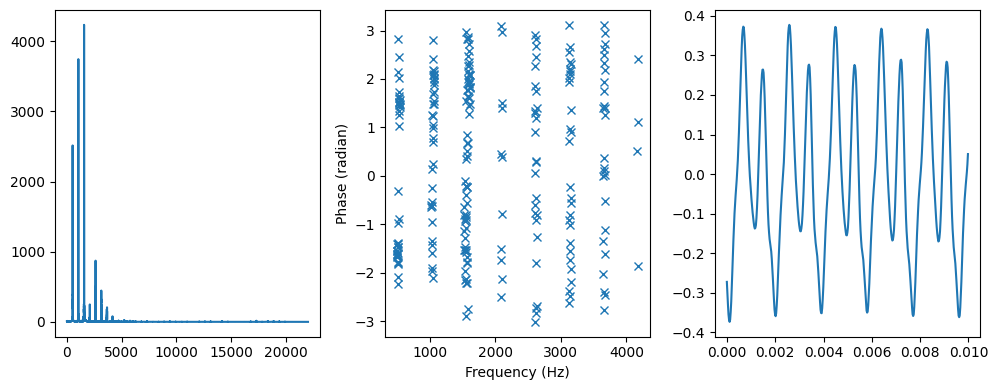

In [57]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Сделаем все углы равными нулю.

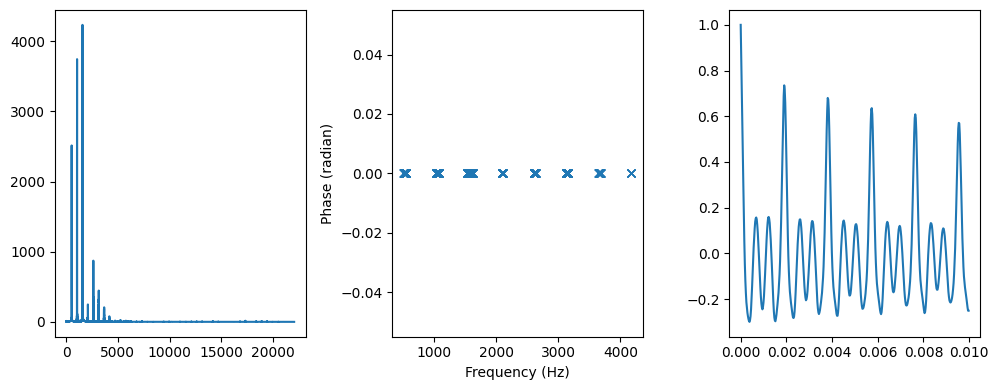

In [60]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

Заметим, что теперь сегмент звучит так, будто амплитуда периодически то возрастает, то уменьшается.

Повернем углы на 2 радиана.

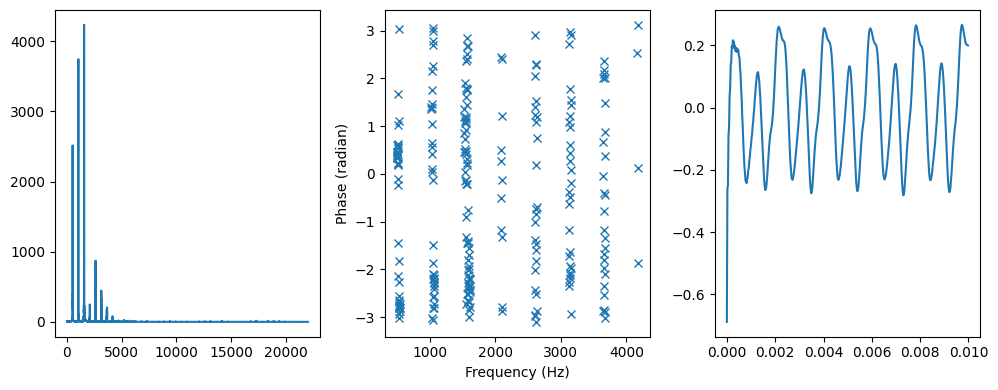

In [65]:
spectrum3 = rotate_angle(spectrum, 2)
plot_three(spectrum3, thresh=50)

Аудиофайл звучит примерно так же.

Рандомизируем углы.

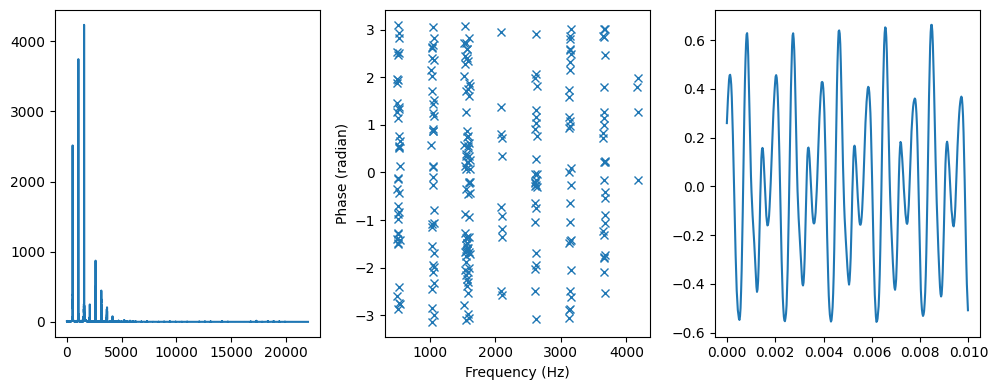

In [66]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Полученный эффект на слух похож на тот, что происходит, когда мы зануляем углы.